In [28]:
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
seq_dim=(6,6)

(array([551., 258., 110.,  51.,  14.,   6.,   6.,   0.,   3.,   1.]),
 array([1.93043967e-04, 8.29479022e-01, 1.65876500e+00, 2.48805098e+00,
        3.31733695e+00, 4.14662293e+00, 4.97590891e+00, 5.80519489e+00,
        6.63448086e+00, 7.46376684e+00, 8.29305282e+00]),
 <BarContainer object of 10 artists>)

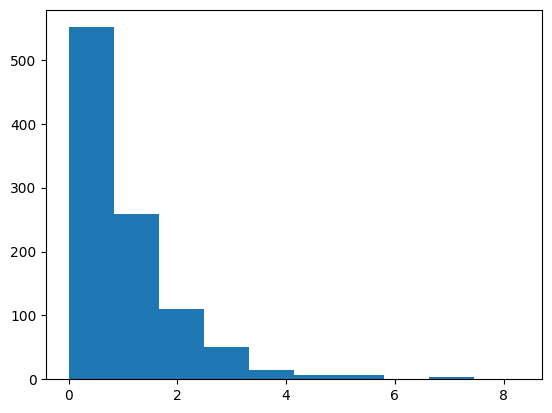

In [29]:
d = scipy.stats.expon().rvs(size=1000)
plt.hist(d)

In [30]:
import torch
import seaborn as sns

In [31]:

class Lattice:
    def __init__(self,L, d, BC='periodic'):
        self.L = L 
        self.d = d
        self.shape = [L]*d 
        self.Nsite = L**d 
        self.BC = BC

    def move(self, idx, d, shift):
        coord = self.index2coord(idx)
        coord[d] += shift

        if self.BC != 'periodic':
            if (coord[d]>=self.L) or (coord[d]<0):
                return None
        #wrap around because of the PBC
        if (coord[d]>=self.L): coord[d] -= self.L; 
        if (coord[d]<0): coord[d] += self.L; 

        return self.coord2index(coord)

    def index2coord(self, idx):
        coord = np.zeros(self.d, int) 
        for d in range(self.d):
            coord[self.d-d-1] = idx%self.L;
            idx /= self.L
        return coord 

    def coord2index(self, coord):
        idx = coord[0]
        for d in range(1, self.d):
            idx *= self.L; 
            idx += coord[d]
        return idx 

class Hypercube(Lattice):
    def __init__(self,L, d, BC='periodic'):
        super(Hypercube, self).__init__(L, d, BC)
        self.Adj = np.zeros((self.Nsite,self.Nsite), int)
        for i in range(self.Nsite):
            for d in range(self.d):
                j = self.move(i, d, 1)

                if j is not None:
                    self.Adj[i, j] = 1.0
                    self.Adj[j, i] = 1.0

from scipy.linalg import eigh, inv, det 
import math
class Ising:
    def __init__(self,L,d,beta,name = None):
        if name is None:
            name = "Ising_l"+str(L)+"_d" +str(d)+"_beta"+str(beta)
        self.beta = 1.0
        self.lattice = Hypercube(L, d, 'periodic')
        self.K = self.lattice.Adj*beta
    
        w, v = eigh(self.K)    
        offset = 0.1-w.min()
        self.K += np.eye(w.size)*offset
        sign, logdet = np.linalg.slogdet(self.K)
        #print (sign)
        #print (0.5*self.nvars[0] *(np.log(4.)-offset - np.log(2.*np.pi)) - 0.5*logdet)
        self.Kinv = torch.from_numpy(inv(self.K)).to(torch.float32)
        self.nvars = [L**d]

    def energy(self,x):
        return -(-0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.Kinv) * x.reshape(-1, self.nvars[0])).sum(dim=1) \
        + (torch.nn.Softplus()(2.*self.beta*x.reshape(-1, self.nvars[0])) - self.beta*x.reshape(-1, self.nvars[0]) - math.log(2.)).sum(dim=1))


    def grad_energy(self,x):
        u = torch.zeros_like(x)
        u = -(-0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.Kinv)) \
        + (1 - torch.nn.functional.sigmoid(-2.*self.beta*x.reshape(-1, self.nvars[0])) - self.beta))
        return u


In [32]:
import torch.autograd as autograd

def jacobian_equaldim(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian

'''
def jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    _y = f(x)
    y=_y.clone()
    for ii in range(N-1):
        y = torch.column_stack([y,_y])

    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian
'''

def jacobian_bp(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x).sum()
    y.backward()
    jacobian = x.grad
    print(jacobian)
    return jacobian

In [63]:
class params():
    def __init__(self):
        self.alphabet_size=2
        self.num_integration_steps=25

hyperparams = params()


def gaussian_flow_inference_2d_plotxx(xx, beta0=0, beta1=1):
    B, H, W = xx.shape
    K = hyperparams.alphabet_size
    
    # xx = torch.concat([torch.normal(-1, 2, size=(int(B/2),H,W)), torch.normal(1, 2, size=(int(B/2),H,W))], dim=0)
    # xx = torch.concat([torch.normal(0, 2, size=(int(B/2),H,W)), torch.normal(0, 2, size=(int(B/2),H,W))], dim=0)

    # np.save(os.path.join(os.environ["work_dir"], "logits_val_inttime%.2f"%0.0), xx.cpu())
    xx_t = []
    xx_t.append(xx)

    ising_source = Ising(6,2,(beta1-beta0))
    eps = 0.8
    decay = .9
    fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(25, 25))
    for ii in range(hyperparams.num_integration_steps):
        ii_y = ii % 5
        ii_x = ii // 5
        logp = -ising_source.energy(xx)

        axes[ii_x,ii_y].hist2d(xx.detach().numpy().reshape(B,H*W)[:,0], xx.detach().numpy().reshape(B,H*W)[:,1], bins=100)
        axes[ii_x,ii_y].set_xlim((-8,8))
        axes[ii_x,ii_y].set_ylim((-8,8))
        axes[ii_x,ii_y].axhline(0,linestyle="--",c="k")
        axes[ii_x,ii_y].axvline(0,linestyle="--",c="k")
        axes[ii_x,ii_y].axhline(6,linestyle="--",c="k")
        axes[ii_x,ii_y].axvline(6,linestyle="--",c="k")
        axes[ii_x,ii_y].set_title("Time = %.4f, eps = %.4f"%(eps*(ii), eps))
        # jacob_mat = -jacobian(ising_source.energy, xx.reshape(B,H*W))
        # tr_jacob = torch.diagonal(jacob_mat, dim1=-2, dim2=-1)
        tr_jacob = -ising_source.grad_energy(xx)
        # print(ii, tr_jacob.min(), tr_jacob.max(), tr_jacob.mean())
        xx = xx + (0.5*eps) * tr_jacob.reshape(B,H,W) + np.sqrt(eps)*torch.rand(xx.shape)
        # xx = xx + (0.5*eps) * jacob_mat@... .reshape(B,H,W) + np.sqrt(eps)*torch.rand(xx.shape)
        eps *= decay

        xx_t.append(xx)

        # np.save(os.path.join(os.environ["work_dir"], "logits_val_inttime%.2f"%(tt)), xx.detach().cpu().numpy())
        # np.save(os.path.join(os.environ["work_dir"], "ut_val_inttime%.2f"%(tt)), u_t.detach().cpu().numpy())
    return xx_t


def gaussian_flow_inference_2d_plotfesmagn(xx, beta0=0, beta1=1):
    B, H, W = xx.shape
    K = hyperparams.alphabet_size
    
    # xx = torch.concat([torch.normal(-1, 2, size=(int(B/2),H,W)), torch.normal(1, 2, size=(int(B/2),H,W))], dim=0)
    # xx = torch.concat([torch.normal(0, 2, size=(int(B/2),H,W)), torch.normal(0, 2, size=(int(B/2),H,W))], dim=0)

    # np.save(os.path.join(os.environ["work_dir"], "logits_val_inttime%.2f"%0.0), xx.cpu())
    xx_t = []
    xx_t.append(xx)

    ising_source = Ising(6,2,(beta1-beta0))
    eps = 0.8
    decay = .9
    fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(25, 25))
    for ii in range(hyperparams.num_integration_steps):
        ii_y = ii % 5
        ii_x = ii // 5
        logp = -ising_source.energy(xx)

        axes[ii_x,ii_y].hist(xx.detach().numpy().reshape(B,H*W).sum(-1), bins=100)
        axes[ii_x,ii_y].set_xlim((-200,200))
        axes[ii_x,ii_y].axvline(0,linestyle="--",c="k")
        axes[ii_x,ii_y].axvline(-36,linestyle="--",c="k")
        axes[ii_x,ii_y].axvline(36,linestyle="--",c="k")
        axes[ii_x,ii_y].set_title("Time = %.4f, eps = %.4f"%(eps*(ii), eps))
        # jacob_mat = -jacobian(ising_source.energy, xx.reshape(B,H*W))
        # tr_jacob = torch.diagonal(jacob_mat, dim1=-2, dim2=-1)
        tr_jacob = -ising_source.grad_energy(xx)
        # print(ii, tr_jacob.min(), tr_jacob.max(), tr_jacob.mean())
        xx = xx + (0.5*eps) * tr_jacob.reshape(B,H,W) + np.sqrt(eps)*torch.rand(xx.shape)
        # xx = xx + (0.5*eps) * jacob_mat@... .reshape(B,H,W) + np.sqrt(eps)*torch.rand(xx.shape)
        eps *= decay

        xx_t.append(xx)

        # np.save(os.path.join(os.environ["work_dir"], "logits_val_inttime%.2f"%(tt)), xx.detach().cpu().numpy())
        # np.save(os.path.join(os.environ["work_dir"], "ut_val_inttime%.2f"%(tt)), u_t.detach().cpu().numpy())
    return xx_t

# $\beta=0 \rightarrow \beta=1.$

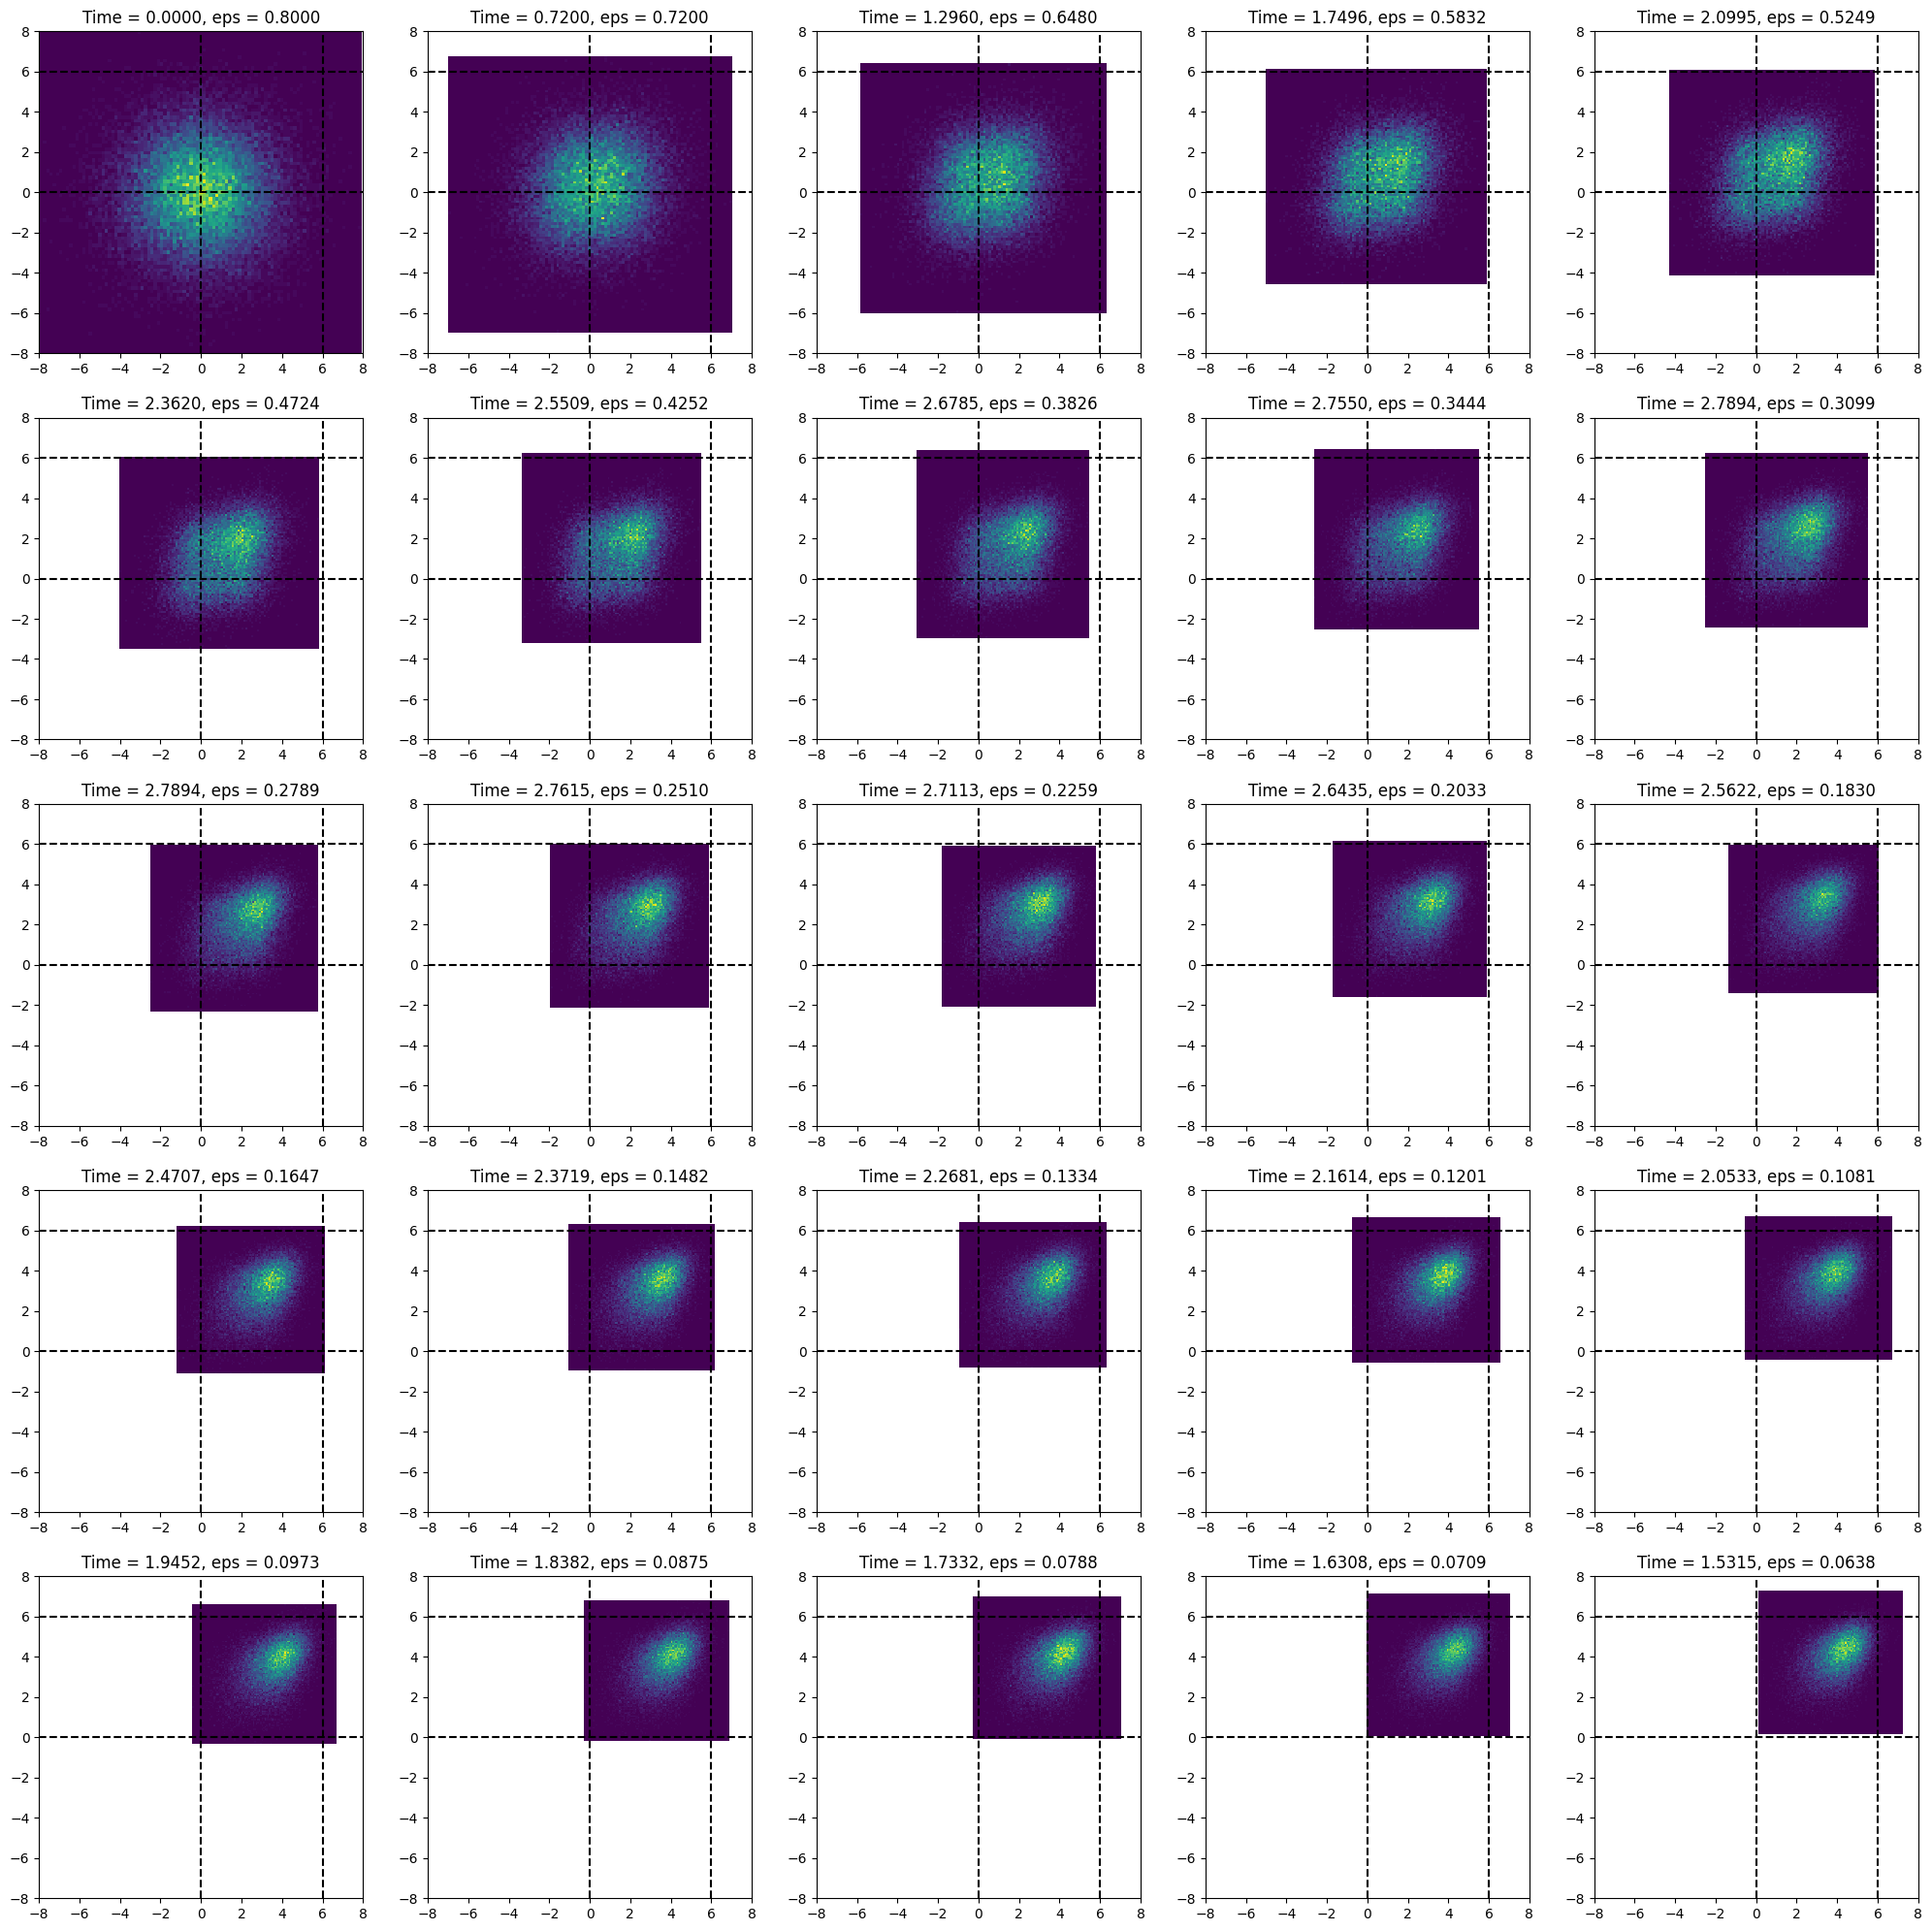

In [58]:
B=2**15
H=6
W=6
xx = torch.concat([torch.normal(0.0001, 2, size=(int(B/2),H,W)), torch.normal(-0.0001, 2, size=(int(B/2),H,W))], dim=0)
xx.requires_grad_(True)
xx_t = gaussian_flow_inference_2d_plotxx(xx, beta0=0, beta1=0.25)

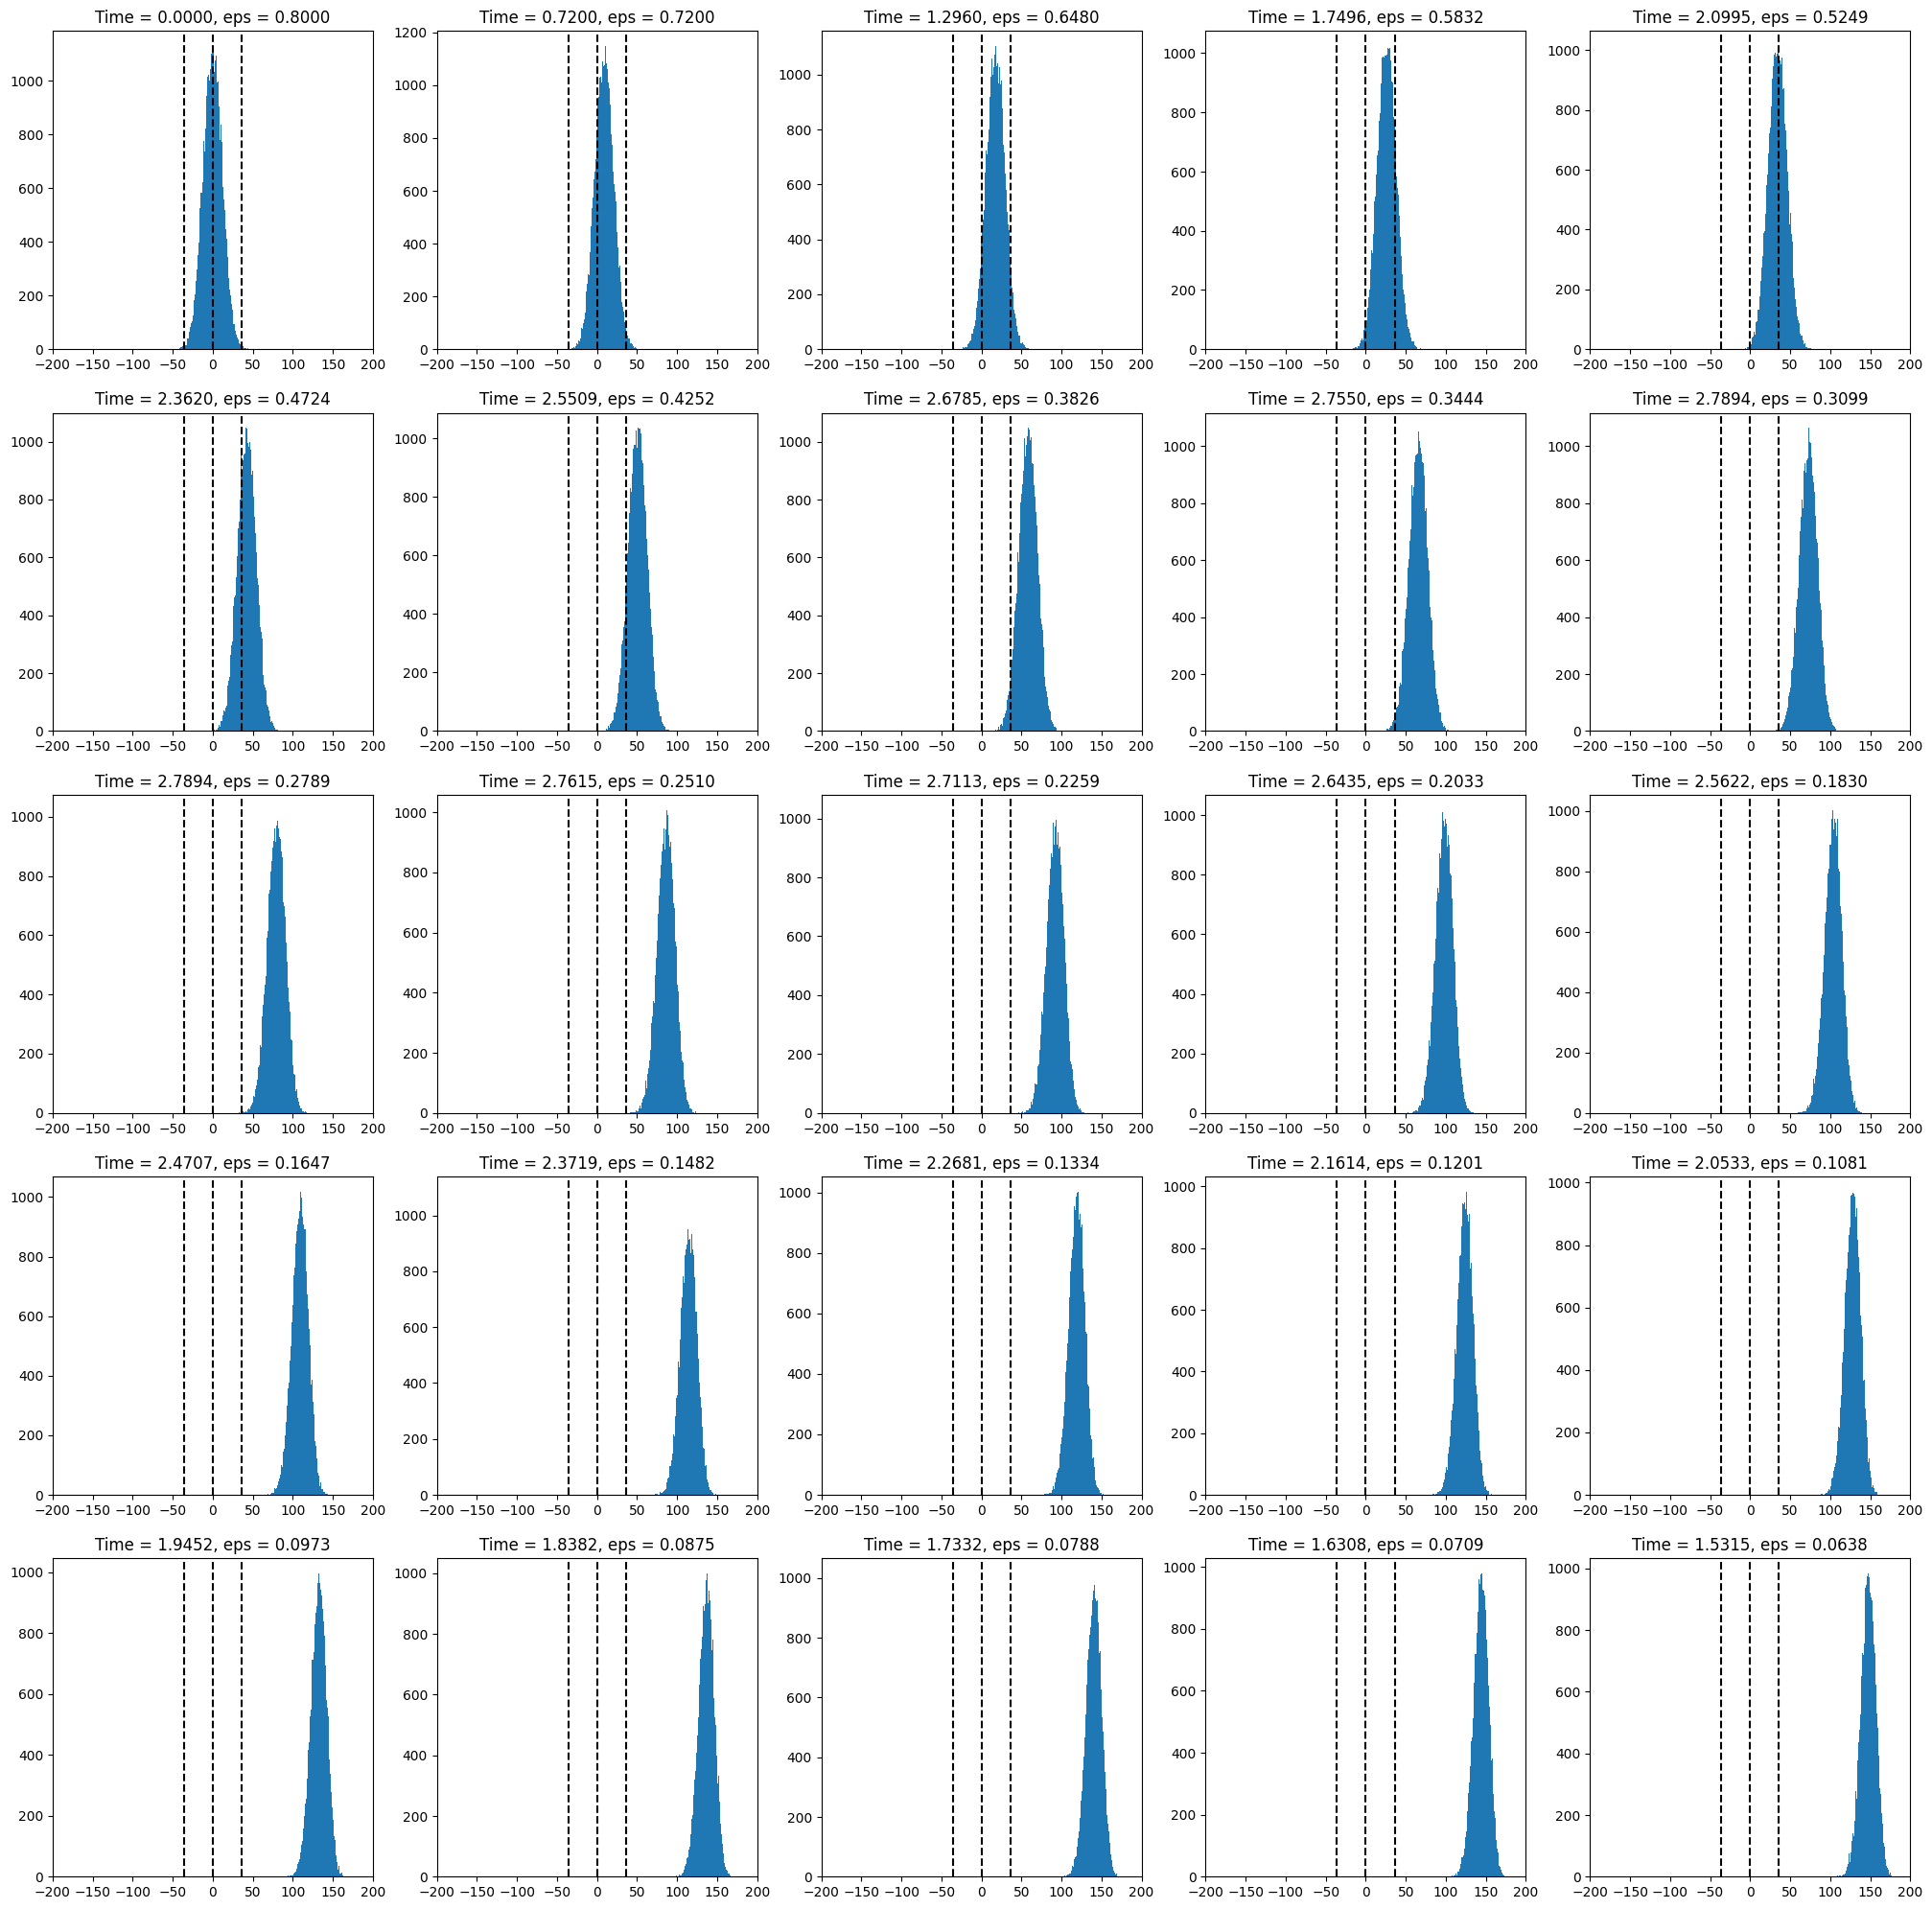

In [64]:
B=2**15
H=6
W=6
xx = torch.concat([torch.normal(0.0001, 2, size=(int(B/2),H,W)), torch.normal(-0.0001, 2, size=(int(B/2),H,W))], dim=0)
xx.requires_grad_(True)
xx_t = gaussian_flow_inference_2d_plotfesmagn(xx, beta0=0, beta1=0.25)